In [1]:
import os
import torch 
import torch.nn as nn
from torch.nn.modules.container import Sequential
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import datetime
import pandas as pd
import copy

In [2]:
device  = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
df = pd.read_csv(r"C:\Users\nevishwakarma\Documents\Projects\Exelon\London_Dataset\dataset\halfhourly_dataset\halfhourly_dataset\block_0.csv", parse_dates=['tstp'])

In [4]:
df['energy(kWh/hh)'] = df['energy(kWh/hh)'].replace('Null', 0)
df['energy(kWh/hh)'] = df['energy(kWh/hh)'].astype(float)

In [5]:
df_train = df[(df['tstp'] > datetime.datetime(2013,1,1)) & (df['tstp'] < datetime.datetime(2014,1,1)) & (df['LCLid'] == "MAC000002")]
df_test = df[(df['tstp'] > datetime.datetime(2014,1,1)) & (df['LCLid'] == "MAC000002")]

In [6]:
training_mean = df_train['energy(kWh/hh)'].mean()
training_std = df_train['energy(kWh/hh)'].std()

df_training_values = (df_train['energy(kWh/hh)'] - training_mean) / training_std

print("Number of training examples : ", len(df_training_values))

Number of training examples :  17519


In [7]:
test_mean = df_test['energy(kWh/hh)'].mean()
test_std = df_test['energy(kWh/hh)'].std()

df_testing_values = (df_test['energy(kWh/hh)'] - test_mean) / test_std

print("Number of training examples : ", len(df_testing_values))

Number of training examples :  2783


In [8]:
def create_sequences(values, time_step = 48):
    
    output = []

    for i in range(0, len(values) - time_step+1, time_step):
        output.append(values[i:(i+time_step)])

    return np.stack(output)

In [9]:

x_train = create_sequences(df_training_values.values)
x_test = create_sequences(df_testing_values.values)

print("Training input shape : ", x_train.shape)
print("Test input shape : ", x_test.shape)

Training input shape :  (364, 48)
Test input shape :  (57, 48)


In [10]:
x_train_float = x_train.astype(np.float32).tolist()
train_loader = [torch.tensor(s).unsqueeze(1).float() for s in x_train_float]

x_test_float = x_test.astype(np.float32).tolist()
test_loader = [torch.tensor(s).unsqueeze(1).float() for s in x_test_float]

In [35]:
class Encoder(nn.Module):

    def __init__(self, sequence_length, number_of_features, embedding_dimension = 64):
        super(Encoder, self).__init__()

        self.sequence_length = sequence_length
        self.number_of_features = number_of_features

        self.embedding_dimension = embedding_dimension
        self.hidden_layer_dimension = 2 * embedding_dimension

        self.lstm1 = nn.LSTM(input_size = self.number_of_features, hidden_size = self.hidden_layer_dimension, num_layers = 1, batch_first = True)

        self.lstm2 = nn.LSTM(input_size = self.hidden_layer_dimension, hidden_size = self.embedding_dimension, num_layers = 1, batch_first = True)

    def forward(self, x):
        x = x.reshape((1, self.sequence_length, self.number_of_features))

        x, (_,_) = self.lstm1(x)
        x, (hidden_n,_) = self.lstm2(x)

        return hidden_n.reshape((self.number_of_features, self.embedding_dimension))

In [36]:
class Decoder(nn.Module):

    def __init__(self, sequence_length, input_dimension = 64, number_of_features = 1):
        super(Decoder, self).__init__()

        self.sequence_length = sequence_length
        self.number_of_features = number_of_features

        self.input_dimension = input_dimension
        self.hidden_layer_dimension = 2 * input_dimension

        self.lstm1 = nn.LSTM(input_size = self.input_dimension, hidden_size = self.input_dimension, num_layers = 1, batch_first = True)

        self.lstm2 = nn.LSTM(input_size = self.input_dimension, hidden_size = self.hidden_layer_dimension, num_layers = 1, batch_first = True)

        self.output_layer = nn.Linear(self.hidden_layer_dimension, self.number_of_features)

    def forward(self, x):
        x = x.repeat(self.sequence_length, self.number_of_features)
        x = x.reshape((self.number_of_features, self.sequence_length, self.input_dimension))

        x, (hidden_n,cell_n) = self.lstm1(x)
        x, (hidden_n,cell_n ) = self.lstm2(x)
        x = x.reshape((self.sequence_length, self.hidden_layer_dimension))

        return self.output_layer(x)

In [37]:
class AutoEncoder(nn.Module):

    def __init__(self, sequence_length, number_of_features, embedding_dimension = 64):
        super(AutoEncoder, self).__init__()

        self.encoder = Encoder(sequence_length, number_of_features, embedding_dimension).to(device)
        self.decoder = Decoder(sequence_length, embedding_dimension, number_of_features).to(device)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

In [38]:
model = AutoEncoder(48,1,8).to(device)
print(model)

AutoEncoder(
  (encoder): Encoder(
    (lstm1): LSTM(1, 16, batch_first=True)
    (lstm2): LSTM(16, 8, batch_first=True)
  )
  (decoder): Decoder(
    (lstm1): LSTM(8, 8, batch_first=True)
    (lstm2): LSTM(8, 16, batch_first=True)
    (output_layer): Linear(in_features=16, out_features=1, bias=True)
  )
)


In [39]:
epochs = 200
lr = 1e-3
batch_size = 64

In [40]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [41]:
def training():
    training_loss = []
    for epoch in range(epochs):
        running_loss = 0.0

        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, data)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        loss = running_loss / len(train_loader)
        training_loss.append(loss)
        print("Epoch {} of {}, Train Loss: {:.3f}".format(epoch+1, epochs, loss))

    return train_loss

In [42]:
train_loss = training()

Epoch 1 of 200, Train Loss: 0.998
Epoch 2 of 200, Train Loss: 0.947
Epoch 3 of 200, Train Loss: 0.910
Epoch 4 of 200, Train Loss: 0.872
Epoch 5 of 200, Train Loss: 0.769
Epoch 6 of 200, Train Loss: 0.749
Epoch 7 of 200, Train Loss: 0.725
Epoch 8 of 200, Train Loss: 0.725
Epoch 9 of 200, Train Loss: 0.707
Epoch 10 of 200, Train Loss: 0.712
Epoch 11 of 200, Train Loss: 0.712
Epoch 12 of 200, Train Loss: 0.700
Epoch 13 of 200, Train Loss: 0.696
Epoch 14 of 200, Train Loss: 0.683
Epoch 15 of 200, Train Loss: 0.713
Epoch 16 of 200, Train Loss: 0.701
Epoch 17 of 200, Train Loss: 0.678
Epoch 18 of 200, Train Loss: 0.664
Epoch 19 of 200, Train Loss: 0.666
Epoch 20 of 200, Train Loss: 0.659
Epoch 21 of 200, Train Loss: 0.679
Epoch 22 of 200, Train Loss: 0.662
Epoch 23 of 200, Train Loss: 0.663
Epoch 24 of 200, Train Loss: 0.679
Epoch 25 of 200, Train Loss: 0.678
Epoch 26 of 200, Train Loss: 0.657
Epoch 27 of 200, Train Loss: 0.653
Epoch 28 of 200, Train Loss: 0.630
Epoch 29 of 200, Train Loss: 

KeyboardInterrupt: 

In [43]:
plt.figure()
plt.plot(train_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")

NameError: name 'train_loss' is not defined

<Figure size 432x288 with 0 Axes>

In [44]:
class EncoderNN(nn.Module):

    def __init__(self):
        super(EncoderNN, self).__init__()

        self.encoder = Sequential(                
                nn.Linear(48, 32),  
                nn.Tanh(),
                nn.Linear(32, 16),  
                nn.Tanh(), 
                nn.Linear(16, 8),  
                nn.Tanh()
        )

    def forward(self, x):
        return self.encoder(x)

In [45]:
class DecoderNN(nn.Module):

    def __init__(self):
        super(DecoderNN, self).__init__()

        self.decoder = Sequential(   
                nn.Linear(8, 16),  
                nn.Tanh(), 
                nn.Linear(16, 32),  
                nn.Tanh(), 
                nn.Linear(32, 48),  
                nn.Tanh()
        )

    def forward(self, x):
        return self.decoder(x)

In [61]:
class AutoencoderNN(nn.Module):

  def __init__(self):
    super(AutoencoderNN,self).__init__()
    
    self.encoderNN = EncoderNN().to(device)
    self.decoderNN = DecoderNN().to(device)


  def forward(self,x):
    x = self.encoderNN(x)
    x = self.decoderNN(x)
    return x

In [62]:
modelNN = torch.load(r'C:\Users\nevishwakarma\Documents\Projects\Exelon\ExelonHotSockets\notebooks\ae_nn.pt')
modelNN.eval()

AutoencoderNN(
  (encoderNN): EncoderNN(
    (encoder): Sequential(
      (0): Linear(in_features=48, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=16, bias=True)
      (3): Tanh()
      (4): Linear(in_features=16, out_features=8, bias=True)
      (5): Tanh()
    )
  )
  (decoderNN): DecoderNN(
    (decoder): Sequential(
      (0): Linear(in_features=8, out_features=16, bias=True)
      (1): Tanh()
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): Tanh()
      (4): Linear(in_features=32, out_features=48, bias=True)
      (5): Tanh()
    )
  )
)

In [63]:
def predict(model, dataset):
    predictiones, losses = [], []
    with torch.no_grad():
        model = model.eval()
        for seq_true in dataset:
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)

            predictiones.append(seq_pred.cpu().numpy().flatten())

            losses.append(loss.item())

    return predictiones, losses

In [65]:
x_test_pred, _ = predict(model, test_loader)

In [64]:
x_testnn_t = torch.Tensor(x_test)

x_testnn_pred = modelNN(x_testnn_t).to('cpu').detach().numpy()


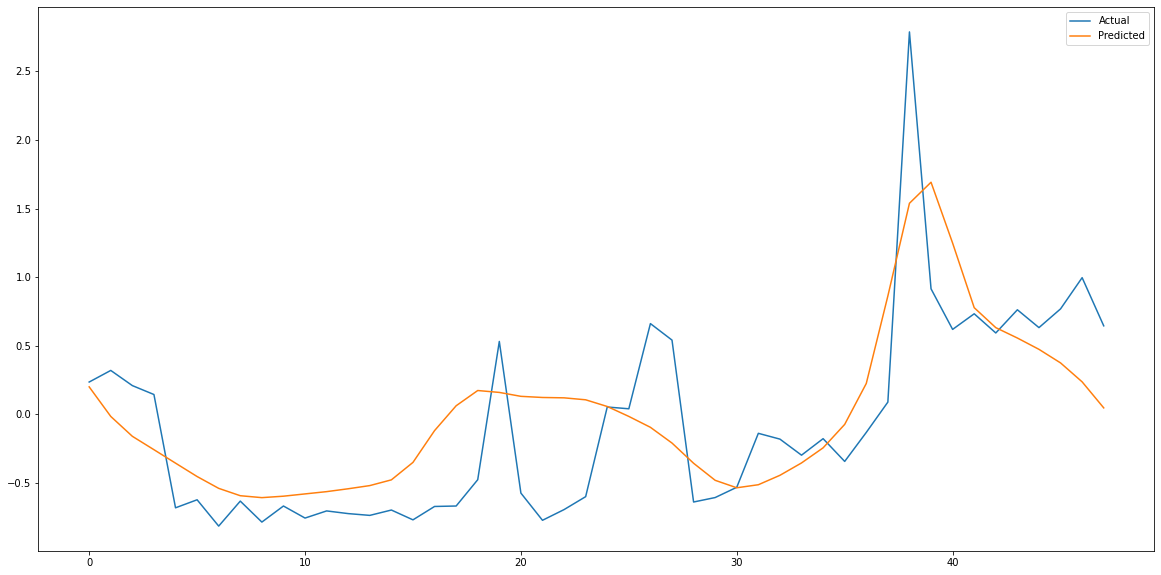

In [24]:
plt.figure(figsize=(20,10))
plt.plot(x_test[5], label='Actual')
plt.plot(x_test_pred[5], label="Predicted")
plt.legend(loc='upper right')
plt.show()

In [ ]:
x_train_pred, _ = predict(model, train_loader)

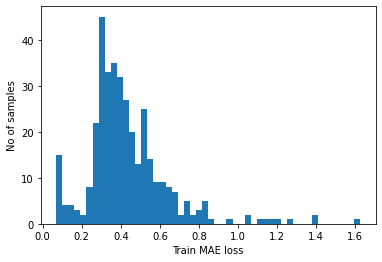

Reconstruction error threshold:  1.6258168742889019


In [27]:
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

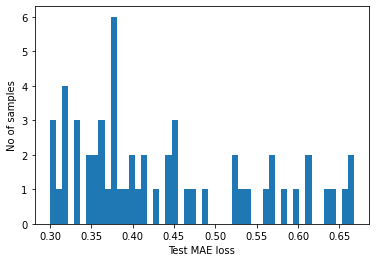

Reconstruction error threshold:  0.6679400226890501


In [25]:
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel("Test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(test_mae_loss)
print("Reconstruction error threshold: ", threshold)

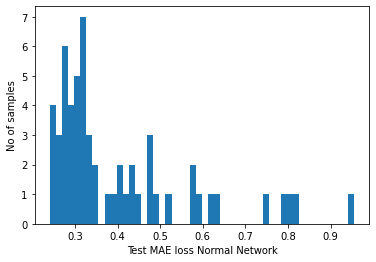

Reconstruction error threshold NN:  0.6679400226890501


In [66]:
test_mae_loss_nn = np.mean(np.abs(x_testnn_pred - x_test), axis=1)

plt.hist(test_mae_loss_nn, bins=50)
plt.xlabel("Test MAE loss Normal Network")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold_nn = np.max(test_mae_loss)
print("Reconstruction error threshold NN: ", threshold_nn)

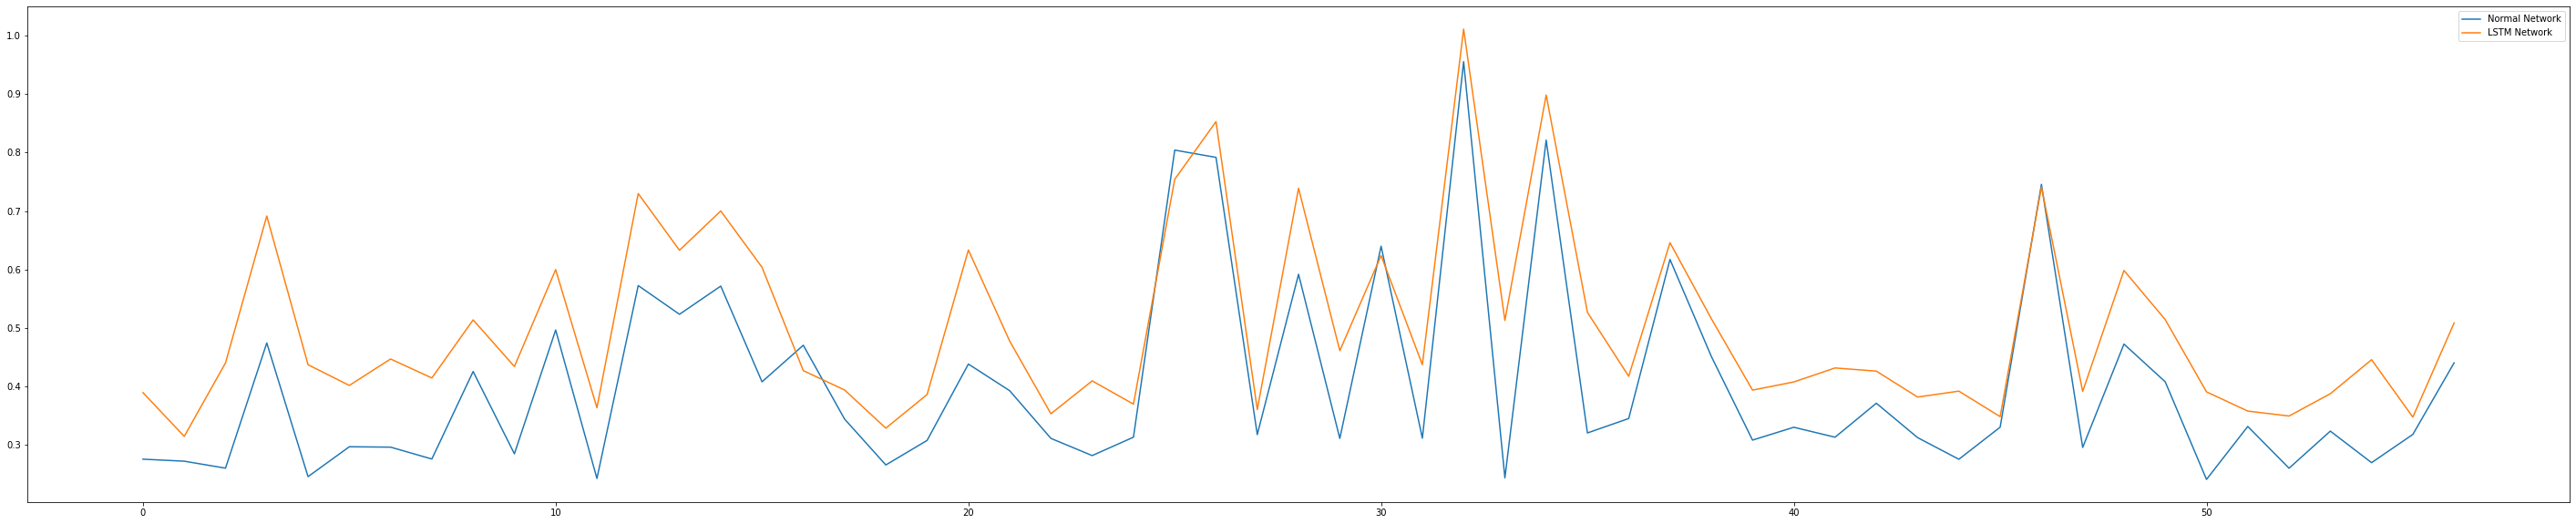

In [71]:
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss_nn = np.mean(np.abs(x_testnn_pred - x_test), axis=1)

plt.figure(figsize=(50,10))
plt.plot(test_mae_loss_nn, label="Normal Network")
plt.plot(test_mae_loss, label="LSTM Network")
plt.legend(loc='upper right')
plt.show()




## Trash Code

In [93]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [94]:
# train_loss = training(model, train_loader, 1000)
model, history = train_model(
  model, 
  train_dataset, 
  test_dataset, 
  n_epochs=150
)


Epoch 1: train loss 0.957813502360995 val loss 0.9122267124945658
Epoch 2: train loss 0.8213449584698858 val loss 0.8294592290593866
Epoch 3: train loss 0.7803045006898733 val loss 0.6030988664480678
Epoch 4: train loss 0.7512511334709495 val loss 0.5813429339935905
Epoch 5: train loss 0.7370064720501203 val loss 0.5801406238685575
Epoch 6: train loss 0.7277135127249614 val loss 0.6092716099923117
Epoch 7: train loss 0.7263510809766108 val loss 0.58209577072085
Epoch 8: train loss 0.7157261541092789 val loss 0.5923941647797301
Epoch 9: train loss 0.708316099592024 val loss 0.6090624217401471
Epoch 10: train loss 0.705819194115555 val loss 0.5864616347509518
Epoch 11: train loss 0.7076562215717366 val loss 0.5862854277355629
Epoch 12: train loss 0.6962520443107728 val loss 0.5493993374862169
Epoch 13: train loss 0.6783536511708746 val loss 0.5465361130864996
Epoch 14: train loss 0.6761365704785951 val loss 0.5458412421377081
Epoch 15: train loss 0.6701457612114129 val loss 0.54357988583

KeyboardInterrupt: 

Text(0, 0.5, 'Loss')

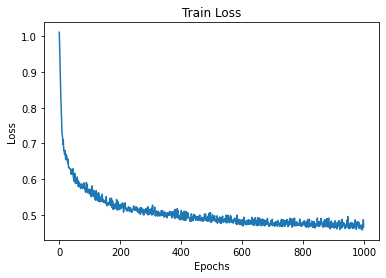

In [95]:
plt.figure()
plt.plot(train_loss)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [101]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

In [102]:
predictions, pred_losses = predict(model, train_loader)


In [107]:
len(predictions)

364

In [ ]:
x_train_t = torch.Tensor(train_loader)

x_train_pred = model(x_train_t).to('cpu').detach().numpy()

train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

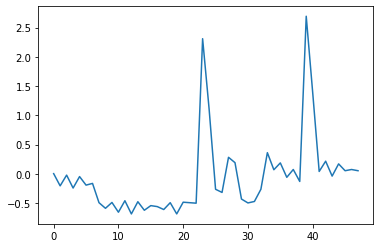

In [97]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
#plt.plot(x_train_pred[1])
plt.show()

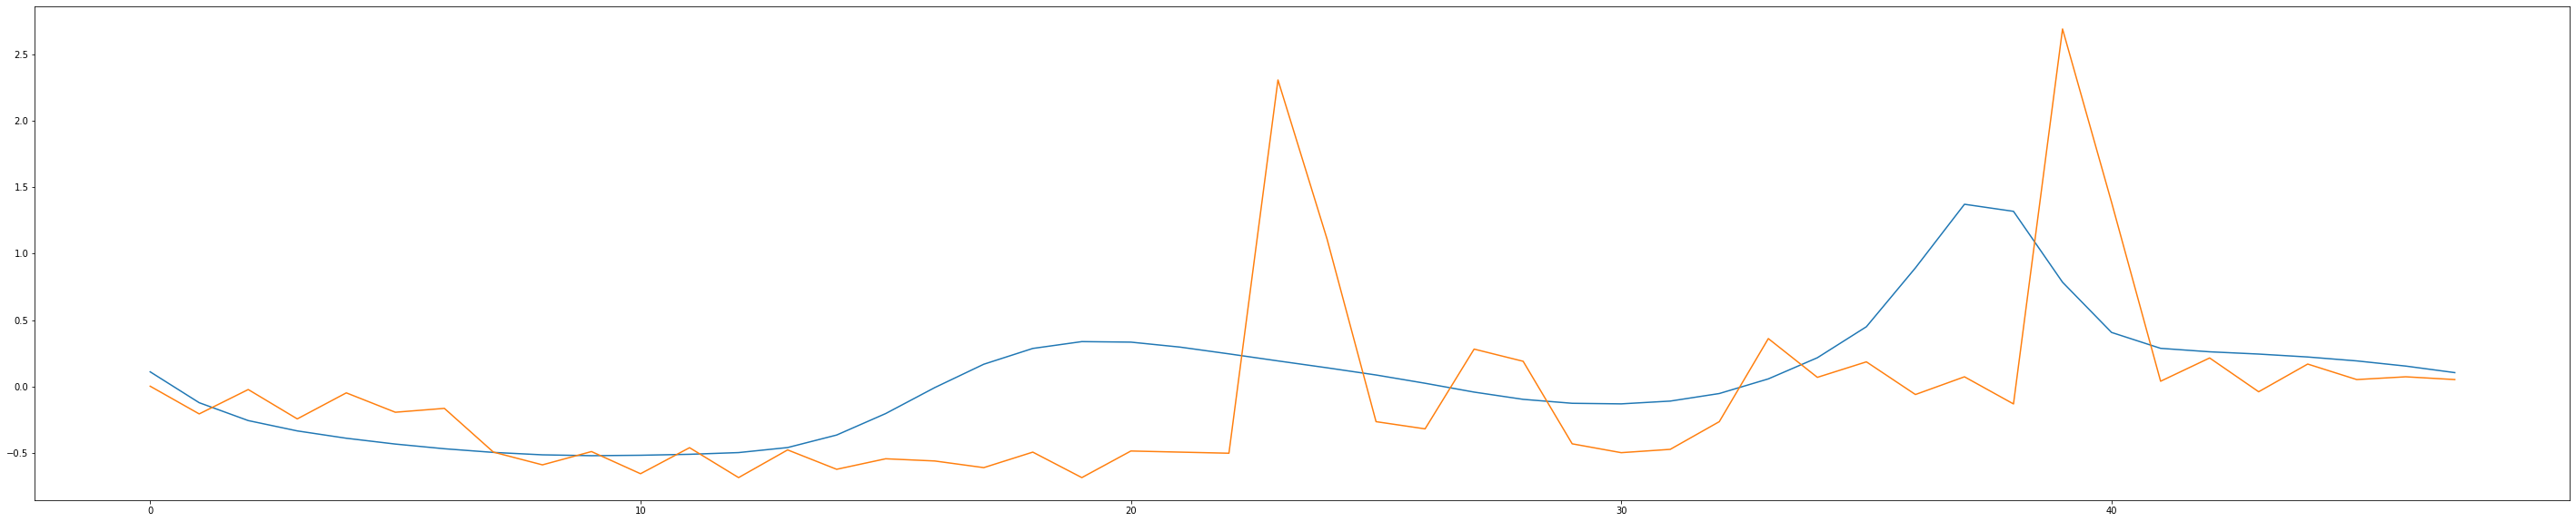

In [109]:
# Checking how the first sequence is learnt
fig = plt.figure(figsize = (50, 10))
plt.plot(predictions[0])
plt.plot(x_train[0])
plt.show()

In [111]:
# x_test_t = torch.Tensor(x_test)

# x_test_pred = model(x_test_t).to('cpu').detach().numpy()

test_predictions, pred_losses = predict(model, test_loader)



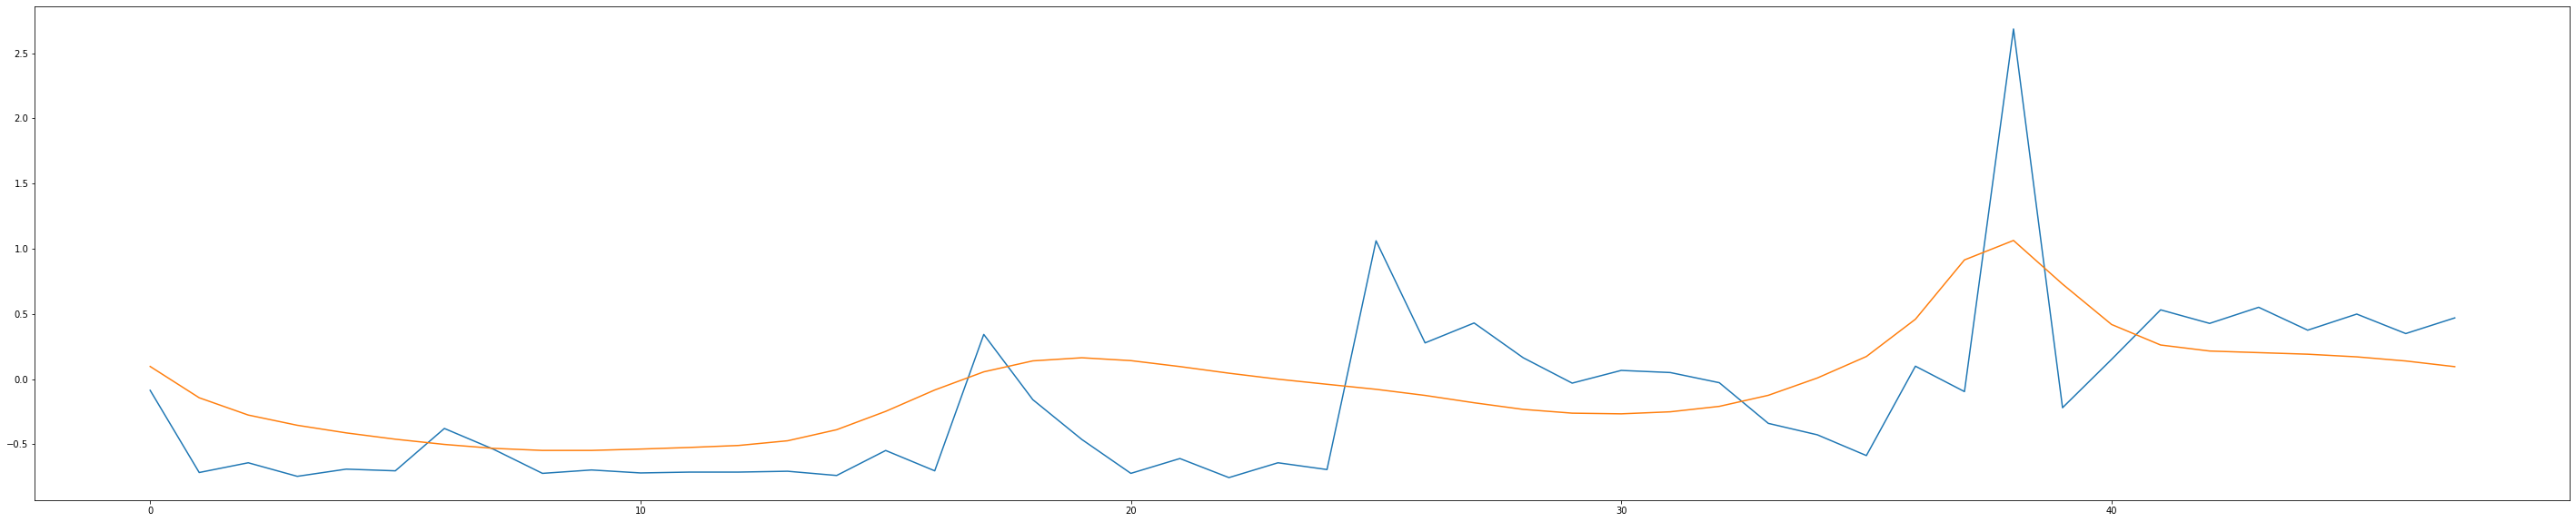

In [114]:
plt.figure(figsize = (50, 10))
plt.plot(x_test[51])
plt.plot(test_predictions[51])
plt.show()